This notebook is a quick introduction on using `geobed` to find optimal designs for non-linear models. We will use the example of a seismic source location in a 2D homogeneous medium. Here the main concepts of the package are introduced, and the reader is referred to the documentation for more details.

# Getting Started

In [1]:
import torch
import torch.distributions as dist

from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle_background.mplstyle')

/tmp/ipykernel_138441/3756262623.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from geobed import BED_base_explicit

```{note}
The 'geobed' package uses the [`pytorch`](https://pytorch.org/) library for its support for probability distributions and automatic differentiation. If readers are familiar with [`numpy`](https://numpy.org/), [`pytorch`](https://pytorch.org/) is very similar, and the documentation is very good. The main difference is that `pytorch` is designed to work with GPUs, and so the default data type is `torch.float32` rather than `numpy.float64`. This means that the default precision is lower than `numpy`, but it is easy to change the data type to `torch.float64` if required.
```

The ingredients for the design problem are:
- a probability distribution function (pdf) describing the prior information on the model parameters (the source location in our case)
- a forward model that maps the model parameters to the data (the travel times in our case)
- a data likelihood function that returns the probability of observing the data given the model parameters

We will now go through each of these ingredients in turn.

## The model parameters

The model parameters are the parameters that we want to estimate. In our case, we want to estimate the location of a seismic source. We will assume that the source location is described by a 2D vector $\mathbf{m} = (x, y)$, where $x$ and $y$ are the coordinates of the source location. We will now assume that the prior information on the source location is described by a multivariate Gaussian distribution with mean $\mathbf{\mu}_m$ and covariance matrix $\mathbf{C}_m$. The covariance matrix defined by its angle, ratio and scaling.

In [3]:
from helpers import construct_covmat

prior_mean = torch.tensor([0.0, -3e3])
prior_cov = construct_covmat(60, 3, 0.3e3)

m_prior_dist = dist.MultivariateNormal(
    prior_mean, prior_cov
)

The variable `m_prior_dist` is a [`MultivariateNormal`](torch.distributions.multivariate_normal.MultivariateNormal) object that describes the prior information on the model parameters.

In [4]:
m_prior_dist

MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))

In general, the prior information can be described by any probability distribution function (pdf) that is implemented in PyTorch. The pdf must be a subclass of [`Distribution`](torch.distributions.distribution.Distribution). Be carfull to define the event shape of the pdf correctly. In our case, the event shape is 2, since we have two model parameters. If we had a independent Gaussian prior on each model parameter we could also use the :mod:'torch.distributions.Independent' class to define the prior information by using the [`Normal`](torch.distributions.normal.Normal) class as follows:

```python
m_prior_dist = torch.distributions.Independent(
    torch.distributions.Normal(loc=torch.tensor([0., 0.]), scale=torch.tensor([1., 1.])),
    reinterpreted_batch_ndims=1)
```

We can now sample from and evaluate the prior distribution to see what the prior information looks like.

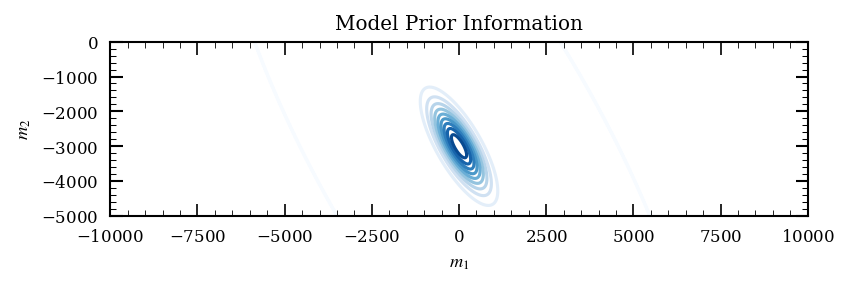

In [5]:
x_min, x_max = -10e3, 10e3
y_min, y_max =  -5e3,  0e3

X, Y = torch.meshgrid(torch.linspace(x_min, x_max, 1000), torch.linspace(y_min, y_max, 1000), indexing='ij')

fig, ax = plt.subplots(figsize=(6,3))

# use only pytotch for plotting
ax.contour(
    X, Y, torch.exp(
        m_prior_dist.log_prob(torch.stack([X,Y], dim=-1).reshape(-1, 2))
    ).reshape(1000, 1000),
    levels=10, cmap='Blues', zorder=-10, linewidths=1.5, alpha=1.0,
)

ax.set(xlabel=r'$m_1$', ylabel=r'$m_2$',
       xlim=(x_min, x_max), ylim=(y_min, y_max),
       aspect='equal',
       title='Model Prior Information')

plt.show()

## The forward function

The forward function maps the model parameters to the data. In our case, the forward function maps the source location to the travel times. We will assume that the travel times are described by a 1D vector $\mathbf{d}$, where $d_i$ is the travel time from the source to the $i$-th receiver. Since we are assuming that the medium is homogeneous, the travel times are given by the Euclidean distance between the source and the receivers divided by the wave speed $c$ which is assumed to be $c=1500$m/s here.

In [6]:
def forward_function(m, design):
    return torch.cdist(m, design) / 1500

## The data likelihood function

The data likelihood function returns the probability of observing the data given the model parameters. In our case, we will assume that the data likelihood is described by an independent Gaussian distribution with mean determined by the forward function and standard deviation $\sigma_d$. Here we assume that the standard deviation is known, with $\sigma_d=0.1$s. The data likelihood function must have the following signature:

```python
def data_likelihood_func(model_parameters, design):
    ...
    return data_likelihood
```
    
where `model_parameters` is a [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) object containing the model parameters, and `design` is a [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) object containing the design parameters. The data likelihood function must return a [`Distribution`](torch.distributions.distribution.Distribution) object that describes the data likelihood. 

The object returned by the data likelihood function is a [`Independent`](torch.distributions.independent.Independent) object that describes the data likelihood. Instead of using the [`Independent`](torch.distributions.independent.Independent) class, we could also use the [`MultivariateNormal`](torch.distributions.multivariate_normal.MultivariateNormal) class to define the data likelihood as follows:

```python
d_likelihood_dist = torch.distributions.MultivariateNormal(
    loc=forward(m_prior_dist.sample()),
    covariance_matrix=torch.diag(torch.tensor([sigma_d**2 for _ in range(n_receivers)])))
```

In [7]:
def data_likelihood_func(model_samples, design):
    sigma = 0.1
    
    return dist.Independent(
        dist.Normal(forward_function(model_samples, design), sigma), 1)

In [8]:
# test design consisting of 2 receivers 
# at -1000m and 1000m offset
test_design = torch.tensor([[-1000.0, 0.0], [1000.0, 0.0]])

# sample 3 models from the prior
test_models = m_prior_dist.sample((3,))

test_data_likelihood = data_likelihood_func(
    test_models, test_design
)

print(test_data_likelihood)
print('Event shape:', test_data_likelihood.event_shape)
print('Batch shape:', test_data_likelihood.batch_shape)

Independent(Normal(loc: torch.Size([3, 2]), scale: torch.Size([3, 2])), 1)
Event shape: torch.Size([2])
Batch shape: torch.Size([3])


As we can see if we have a design consiting of two receivers the event shape of the data likelihood is two. Since we evaluate the data likelihood for three samples from the prior distribution, the batch shape is three.

We will show plots to illustrate the forward function and the data likelihood function later.

## Experimental Design

With the model parameters, the forward function and the data likelihood function defined, we can now initialise the [`BED_base_explicit`](geobed.core.BED_base_explicit) class. This class implents a number of convenience functions as well as the main functions for calculating the EIG which determines the quality of the design. We use the explicit version of the class here, since we do not have any nuisance parameters and we can explicitly evaluate the data likelihood function.

The class is initialised as follows: 

In [9]:
BED_class = BED_base_explicit(
    m_prior_dist         = m_prior_dist,
    data_likelihood_func = data_likelihood_func,
)

We can no define the design space, which in this case is the set of possible receiver locations. We will assume that the receivers are located on the surface at $y=0$m, and that the receivers are located between $x=-10$km and $x=10$km. For numerical reasons, we will assume that the design space is a equidistant grid with $n_{design}=100$ design points. Using other optimisation methods, we could also use a continuous design space.

In [10]:
n_design_points = 100

design_points = torch.stack(
    [torch.linspace(x_min, x_max, n_design_points),
     torch.ones(n_design_points) * y_max],
    dim=1)

design_space =  design_points.unsqueeze(1)

With the design points and the [`BED_base_explicit`](geobed.core.BED_base_explicit) class defined, we can illustrate the excpected data for this design problem. This provides a sanity check that the forward function and the data likelihood function are defined correctly. For this we use the convenience function [`get_data_likelihood_samples`](geobed.core.BED_base_explicit.get_data_likelihood_samples) which returns a [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) object with shape (n_data_likelihood_samples, n_model_parameters, n_design) containing samples from the data likelihood function. We can then plot the expected data for each of the design points.

In [11]:
n_model_samples=10000

noisy_data, _ = BED_class.get_data_likelihood_samples(
    design=design_points,
    n_model_samples=n_model_samples,
)

print(noisy_data.shape)

torch.Size([10000, 100])


As we can see the output of the [`get_data_likelihood_samples`](geobed.core.BED_base_explicit.get_data_likelihood_samples) function is a tensor of shape `n_model_samples` x `n_design_points`.

To visualise the data we can now plot a 2D histogramm of the predicted travel times for each design point. We can also plot the travel times for a single design point to see how the travel times change for different receiver locations. 

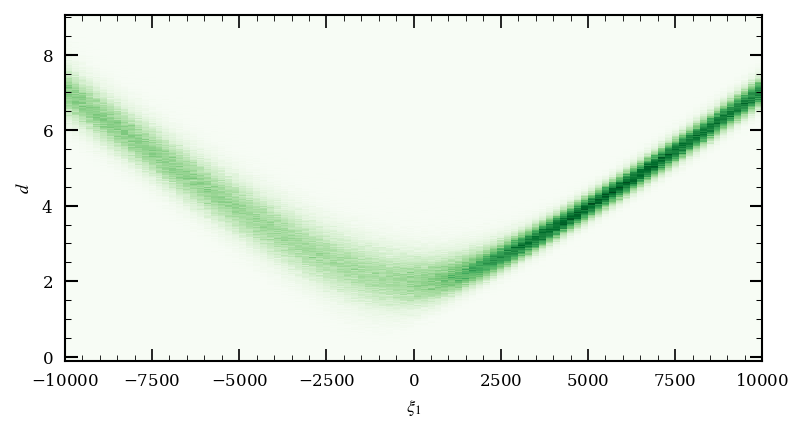

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.hist2d(
    design_points[..., 0].repeat(n_model_samples, 1).flatten(),
    noisy_data.flatten(),
    bins=[n_design_points, 500], cmap='Greens'
    )

ax.set_xlabel(r'$\xi_1$')
ax.set_ylabel(r'$d$')

plt.show()

We can now solve the design problem by calculating the EIG for each design point. We can then plot the EIG to see which design point is the best. To do this we will use the so-called [`NMC`](geobed.eig.nmc) method which is a Monte Carlo method to calculate the EIG. For more information on this an alternative methods to calculate the EIG see the documentation or the tutorial on [Different Methods of Calculating the EIG](https://geobed.readthedocs.io/en/stabel/tutorials/eig_methods.html).   

In [13]:
nmc_eig, nmc_info = BED_class.calculate_EIG(
    design=design_space,
    eig_method='NMC',
    eig_method_kwargs=dict(
        N                = int(1e3),
        reuse_M          = True,
        memory_efficient = True,
        ),
    random_seed=0,
    progress_bar=True,
)

Calculating eig:   0%|          | 0/100 [00:00<?, ?it/s]

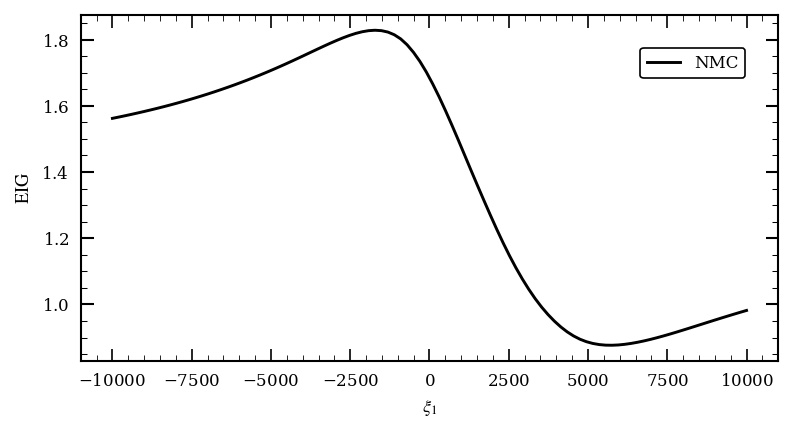

Optimal design point: x=-1717.17, y=0.00


In [14]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(design_points[..., 0], nmc_eig,
        label='NMC', color='k')

ax.set_xlabel(r'$\xi_1$')
ax.set_ylabel(r'$\mathrm{EIG}$')

ax.legend()

plt.show()

optimal_design_point = design_points[nmc_eig.argmax()]

print(f'Optimal design point: x={optimal_design_point[0]:.2f}, y={optimal_design_point[1]:.2f}')

We have now solved the design problem and found the best design point for a 1-receiver seismic source location problem. For more than one receiver we can provide the [`calculate_EIG`](geobed.core.BED_base.calculate_EIG) to an optimisation algorithm to find the best design.

Below we show how to use sequential construction to find the best design for a 5-receiver seismic source location problem.

In [15]:
n_rec = 5

optimal_design = [design_points[nmc_eig.argmax()],]

print(f'Best initial offset: {optimal_design[0][0]}')

eig_array = torch.zeros(n_rec, n_design_points)
eig_array[0] = nmc_eig

for i in tqdm(range(1, n_rec)):
    # add optimal design point to the second dimension of the design space
    tmp_ds = torch.hstack(
        [design_space,
         torch.stack(optimal_design)[None].repeat(n_design_points, 1, 1)])
    
    eig, _ = BED_class.calculate_EIG(
        design=tmp_ds,
        eig_method='NMC',
        eig_method_kwargs=dict(
            N                = int(1e3),
            reuse_M          = True,
            memory_efficient = False,
            ),
        random_seed=0,
        # num_workers=10,
        progress_bar=False,
    )
    eig_array[i] = eig
    
    optimal_design.append(design_points[eig.argmax()])
    
    print(f'Best offset for the {i+1}. receiver: {optimal_design[-1][0]:.2f}')
    
optimal_design = torch.stack(optimal_design)

Best initial offset: -1717.171630859375


  0%|          | 0/4 [00:00<?, ?it/s]

Best offset for the 2. receiver: 5555.56
Best offset for the 3. receiver: -2525.25
Best offset for the 4. receiver: 1717.17
Best offset for the 5. receiver: -10000.00


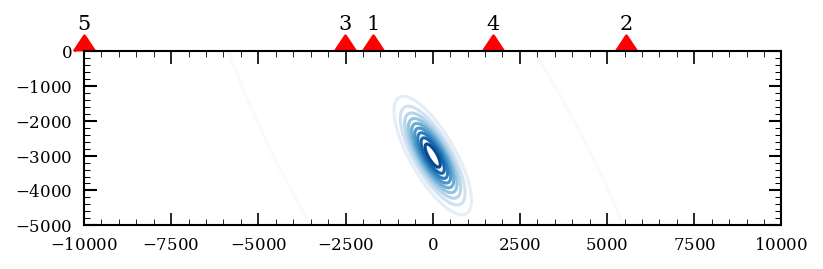

In [16]:
fig, ax = plt.subplots(figsize=(6, 2))

ax.contour(
    X, Y, torch.exp(
        m_prior_dist.log_prob(torch.stack([X,Y], dim=-1).reshape(-1, 2))
    ).reshape(1000, 1000),
    levels=10, cmap='Blues', zorder=-10, linewidths=1.5, alpha=1.0,
)

ax.scatter(
    optimal_design[..., 0],
    optimal_design[..., 1],
    marker=10, s=100, color='r',
    clip_on=False, 
)
for i, (x, y) in enumerate(optimal_design):
    ax.text(x, y+500, f'{i+1}', fontsize=10, ha='center', va='bottom')


ax.set_aspect('equal')


plt.show()

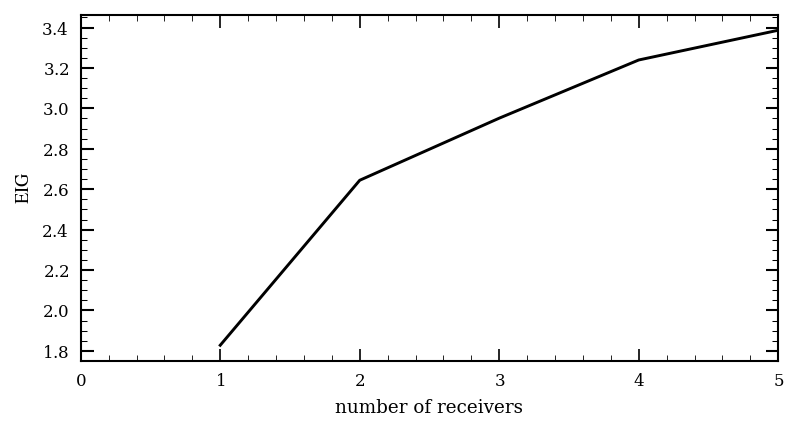

In [17]:
fig, ax = plt.subplots(figsize=(6, 3))

plt.plot(
    torch.arange(1, n_rec+1),
    eig_array.max(1).values, label='EIG', color='k')

ax.set_xlim(0, n_rec)

ax.set_xlabel('number of receivers')
ax.set_ylabel(r'$\mathrm{EIG}$')

plt.show()